Project: Taxi Tip Prediction
Data: 2021 January - yellow taxi trip records
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page


In [ ]:
import pandas as pd
import numpy as np 
import math 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
tx = pd.read_csv("/content/taxipred.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
tx.describe() #to see if the data is following normal distribution or not.

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1.271413e+06,1.271413e+06,1.369765e+06,1.271413e+06,1.369765e+06,1.369765e+06,1.271413e+06,1.369765e+06,1.369765e+06,1.369765e+06,1.369765e+06,1.369765e+06,1.369765e+06,1.369765e+06,1.369765e+06
mean,1.676925e+00,1.411508e+00,4.631982e+00,1.035081e+00,1.652472e+02,1.614956e+02,1.280521e+00,1.209662e+01,9.705085e-01,4.930411e-01,1.918099e+00,2.477432e-01,2.969412e-01,1.747439e+01,2.116098e+00
std,4.676513e-01,1.059833e+00,3.939042e+02,5.994840e-01,6.783849e+01,7.210800e+01,4.916921e-01,1.291338e+01,1.231256e+00,7.632070e-02,2.597153e+00,1.672755e+00,4.222174e-02,1.469343e+01,9.287277e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.900000e+02,-5.500000e+00,-5.000000e-01,-1.000000e+02,-3.112000e+01,-3.000000e-01,-4.928000e+02,-2.500000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.240000e+02,1.070000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,8.500000e+00,0.000000e+00,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.380000e+01,2.500000e+00
75%,2.000000e+00,1.000000e+00,3.020000e+00,1.000000e+00,2.360000e+02,2.360000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.750000e+00,0.000000e+00,3.000000e-01,1.912000e+01,2.500000e+00
max,2.000000e+00,8.000000e+00,2.631633e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,6.960500e+03,8.250000e+00,5.000000e-01,1.140440e+03,8.117500e+02,3.000000e-01,7.661280e+03,3.000000e+00


In [ ]:
tx.dtypes #to check the datatypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [ ]:
tx.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2.0,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
1,1.0,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1.0,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1.0,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
3,1.0,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1.0,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
4,2.0,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1.0,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5


## **Exploratory Data Analysis** PART 1


In [ ]:
tx.dropna()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2.0,8.0,3.0,0.5,0.00,0.00,0.3,11.80,2.5
1,1.0,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2.0,3.0,0.5,0.5,0.00,0.00,0.3,4.30,0.0
2,1.0,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1.0,42.0,0.5,0.5,8.65,0.00,0.3,51.95,0.0
3,1.0,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1.0,29.0,0.5,0.5,6.05,0.00,0.3,36.35,0.0
4,2.0,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1.0,16.5,0.5,0.5,4.06,0.00,0.3,24.36,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271408,2.0,2021-01-31 23:58:47,2021-02-01 00:04:40,3.0,0.81,1.0,N,41,74,2.0,5.0,0.5,0.5,0.00,0.00,0.3,6.30,0.0
1271409,2.0,2021-01-31 23:07:54,2021-01-31 23:19:42,1.0,3.81,1.0,N,113,141,2.0,12.5,0.5,0.5,0.00,0.00,0.3,16.30,2.5
1271410,2.0,2021-01-31 23:30:45,2021-01-31 23:35:13,1.0,1.32,1.0,N,233,237,2.0,6.0,0.5,0.5,0.00,0.00,0.3,9.80,2.5
1271411,2.0,2021-01-31 23:09:52,2021-01-31 23:51:56,2.0,10.56,1.0,N,56,68,1.0,37.5,0.5,0.5,0.00,6.12,0.3,44.92,0.0


In [ ]:
ntx = tx[(tx.tip_amount > 0 ) & (tx.passenger_count < 6) & (tx.passenger_count >0) & (tx.congestion_surcharge > 0) & (tx.extra > 0) & (tx.mta_tax > 0) & (tx.improvement_surcharge > 0) &(tx.tip_amount > 0) & (tx.fare_amount > 0) & (tx.trip_distance > 0)&(tx.total_amount > 0)&(tx.tip_amount < 1000) & (tx.total_amount < 7000)]

In [ ]:
ntx.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,425237.000000,425237.000000,425237.000000,425237.000000,425237.000000,425237.000000,425237.000000,425237.000000,425237.000000,425237.0,425237.000000,425237.000000,4.252370e+05,425237.000000,425237.0
mean,1.418950,1.292912,2.358713,1.008327,171.002897,168.524145,1.000016,10.092559,1.971245,0.5,2.690102,0.114485,3.000000e-01,16.716272,2.5
std,0.493388,0.734276,2.519344,0.094526,63.948390,70.019115,0.005086,7.102354,1.042583,0.0,2.037993,0.846714,2.030878e-12,9.166066,0.0
min,1.000000,1.000000,0.010000,1.000000,4.000000,1.000000,1.000000,2.500000,0.500000,0.5,0.010000,0.000000,3.000000e-01,6.000000,2.5
25%,1.000000,1.000000,1.020000,1.000000,137.000000,114.000000,1.000000,6.000000,1.000000,0.5,1.760000,0.000000,3.000000e-01,11.760000,2.5
50%,1.000000,1.000000,1.700000,1.000000,163.000000,163.000000,1.000000,8.000000,2.500000,0.5,2.260000,0.000000,3.000000e-01,14.160000,2.5
75%,2.000000,1.000000,2.700000,1.000000,236.000000,236.000000,1.000000,11.500000,2.500000,0.5,3.060000,0.000000,3.000000e-01,18.360000,2.5
max,2.000000,5.000000,267.700000,5.000000,265.000000,265.000000,3.000000,722.000000,7.000000,0.5,369.400000,35.750000,3.000000e-01,1108.200000,2.5


In [ ]:
ntx = ntx.drop('congestion_surcharge', axis = 1)
ntx = ntx.drop('total_amount', axis = 1) #totalamount = tip +fare(hence removing total amount)
ntx = ntx.drop('mta_tax', axis = 1)#mta tax is common 
ntx = ntx.drop('improvement_surcharge', axis = 1) #$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
ntx = ntx.drop('RatecodeID', axis = 1) #The final rate code in effect at the end of the trip.


In [ ]:
ntx.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount
4,2.0,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,N,68,33,1.0,16.5,0.5,4.06,0.0
5,1.0,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.60,N,224,68,1.0,8.0,3.0,2.35,0.0
9,1.0,2021-01-01 00:26:12,2021-01-01 00:39:46,2.0,2.70,N,263,142,1.0,12.0,3.0,3.15,0.0
13,2.0,2021-01-01 00:31:06,2021-01-01 00:38:52,5.0,1.70,N,142,50,1.0,8.0,0.5,2.36,0.0
15,2.0,2021-01-01 00:17:48,2021-01-01 00:21:55,1.0,1.01,N,236,237,1.0,5.5,0.5,1.00,0.0


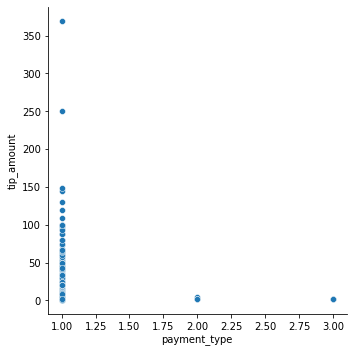

In [ ]:
sns.relplot(y= 'tip_amount', x= 'payment_type', data = ntx)

In [ ]:
ntx = ntx.drop('store_and_fwd_flag', axis = 1)

In [ ]:
ntx = ntx.drop('VendorID', axis = 1)#A code indicating the TPEP provider that provided the record.

2. **Feature Extraction using correlation matrix to check the relation between the variables for prediction; with the help of correlation matrix passenger count, trip distance, payment type start and end time and date are considered.** 

In [ ]:
df = pd.DataFrame(ntx,columns=[ 'tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount'])

In [ ]:
corrMatrix = df.corr()

In [ ]:
print (corrMatrix)#To check the correlation between variables

                 passenger_count  trip_distance  ...  tip_amount  tolls_amount
passenger_count         1.000000       0.010918  ...    0.005402      0.009598
trip_distance           0.010918       1.000000  ...    0.675563      0.545642
PULocationID            0.002257      -0.088926  ...   -0.059647     -0.052263
DOLocationID            0.006613      -0.089484  ...   -0.062153     -0.018435
payment_type           -0.001291      -0.000993  ...   -0.000983     -0.000438
fare_amount             0.006640       0.976333  ...    0.683658      0.505838
extra                  -0.161223       0.036662  ...    0.025065      0.046338
tip_amount              0.005402       0.675563  ...    1.000000      0.406397
tolls_amount            0.009598       0.545642  ...    0.406397      1.000000

[9 rows x 9 columns]


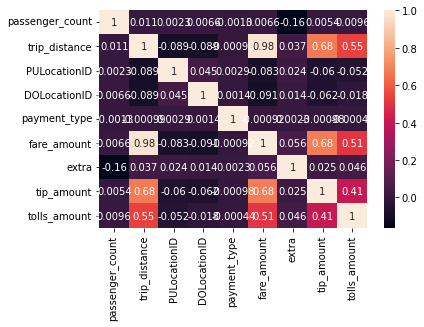

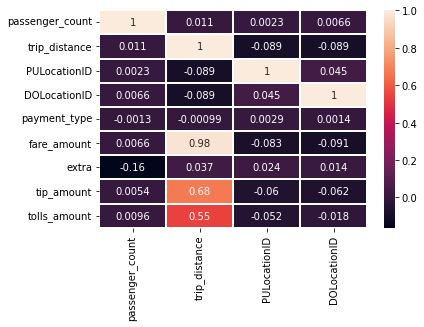

In [ ]:
sns.heatmap(corrMatrix, annot=True)
plt.show()
ax = sns.heatmap(corrMatrix.iloc[:, 0:4:], annot=True, linewidths=1) #To check the correlation 

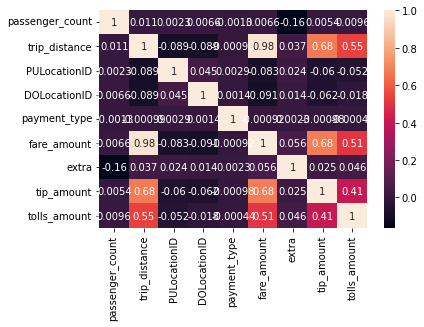

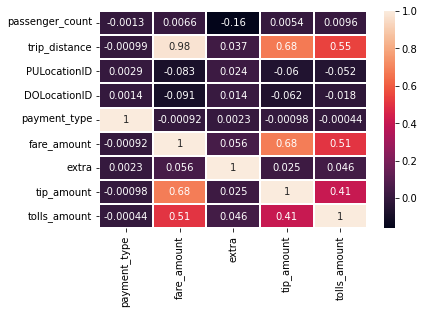

In [ ]:
sns.heatmap(corrMatrix, annot=True)
plt.show()
ax = sns.heatmap(corrMatrix.iloc[:, 4:9:], annot=True, linewidths=1) ##To check the correlation #there is more correlation for trip distance and fare amount with respect to tip amount.

In [ ]:
type(ntx['tpep_pickup_datetime'])
a=pd.to_datetime(ntx['tpep_pickup_datetime'])
b=pd.to_datetime(ntx['tpep_dropoff_datetime'])

**3.Feature transformation: time is represented with the level of time of the day, travel duration and speed.**

*   List item
*   List item



In [ ]:
ntx['time_difference']=b-a

In [ ]:
ntx['trip_duration'] = ntx['time_difference'].dt.total_seconds().div(60).astype(float)
ntx['trip_duration'] #to get the time difference in minutes for considering trip time.

4          16.533333
5           8.016667
9          13.566667
13          7.766667
15          4.116667
             ...    
1271395     7.716667
1271398    22.383333
1271399    12.050000
1271401    23.966667
1271412     7.550000
Name: trip_duration, Length: 425237, dtype: float64

In [ ]:
ntx['trip_duration']=round(ntx['trip_duration'],2)
ntx['trip_duration']

4          16.53
5           8.02
9          13.57
13          7.77
15          4.12
           ...  
1271395     7.72
1271398    22.38
1271399    12.05
1271401    23.97
1271412     7.55
Name: trip_duration, Length: 425237, dtype: float64

In [ ]:
ls=[]
for column in ntx['tpep_pickup_datetime']:
    string = column
    date = datetime.datetime.strptime(string, "%Y-%m-%d  %H:%M:%S")
    if(date.hour <= 12 and date.hour >= 6):
        ls.append("Morning")
    elif(date.hour <= 18 and date.hour >= 13):
        ls.append("Afternoon")
    else:
        ls.append("Night")   #grouping time wrt to morning afternoon and evening

In [ ]:
ntx['Timings'] = ls

In [ ]:
ntx = ntx.drop('tpep_pickup_datetime', axis = 1) 

In [ ]:
ntx = ntx.drop('tpep_dropoff_datetime', axis = 1)

In [ ]:
ntx = ntx.drop('time_difference', axis = 1)

In [ ]:
ntx

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,trip_duration,Timings
4,1.0,4.94,68,33,1.0,16.5,0.5,4.06,0.0,16.53,Night
5,1.0,1.60,224,68,1.0,8.0,3.0,2.35,0.0,8.02,Night
9,2.0,2.70,263,142,1.0,12.0,3.0,3.15,0.0,13.57,Night
13,5.0,1.70,142,50,1.0,8.0,0.5,2.36,0.0,7.77,Night
15,1.0,1.01,236,237,1.0,5.5,0.5,1.00,0.0,4.12,Night
...,...,...,...,...,...,...,...,...,...,...,...
1271395,1.0,2.51,233,262,1.0,9.0,0.5,1.92,0.0,7.72,Night
1271398,1.0,5.52,163,256,1.0,19.5,0.5,4.66,0.0,22.38,Night
1271399,2.0,2.87,230,75,1.0,11.0,0.5,0.20,0.0,12.05,Night
1271401,1.0,11.41,138,249,1.0,32.5,0.5,9.08,0.0,23.97,Night


In [ ]:
ntx["Speed"] = ntx.trip_distance/ntx.trip_duration

In [ ]:
ntx

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,trip_duration,Timings,Speed
4,1.0,4.94,68,33,1.0,16.5,0.5,4.06,0.0,16.53,Night,0.298851
5,1.0,1.60,224,68,1.0,8.0,3.0,2.35,0.0,8.02,Night,0.199501
9,2.0,2.70,263,142,1.0,12.0,3.0,3.15,0.0,13.57,Night,0.198968
13,5.0,1.70,142,50,1.0,8.0,0.5,2.36,0.0,7.77,Night,0.218790
15,1.0,1.01,236,237,1.0,5.5,0.5,1.00,0.0,4.12,Night,0.245146
...,...,...,...,...,...,...,...,...,...,...,...,...
1271395,1.0,2.51,233,262,1.0,9.0,0.5,1.92,0.0,7.72,Night,0.325130
1271398,1.0,5.52,163,256,1.0,19.5,0.5,4.66,0.0,22.38,Night,0.246649
1271399,2.0,2.87,230,75,1.0,11.0,0.5,0.20,0.0,12.05,Night,0.238174
1271401,1.0,11.41,138,249,1.0,32.5,0.5,9.08,0.0,23.97,Night,0.476012


**relation ship between the tip amount and various features**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


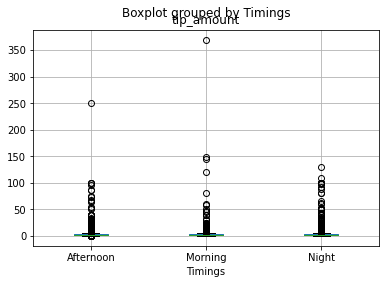

In [ ]:
ntx.boxplot(column='tip_amount',by='Timings')

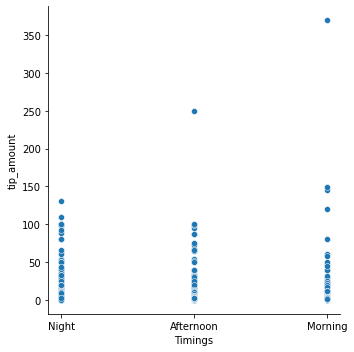

In [ ]:
sns.relplot(y= 'tip_amount', x= 'Timings', data = ntx)

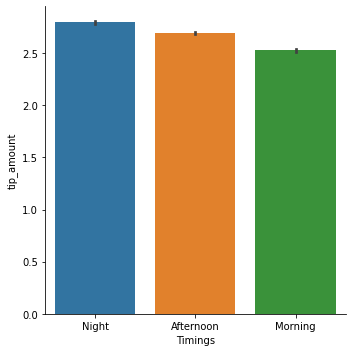

In [ ]:
sns.catplot(x = 'Timings', y = 'tip_amount', kind ='bar', data = ntx)

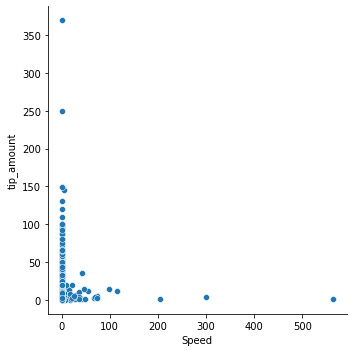

In [ ]:
sns.relplot(x= 'Speed', y = 'tip_amount', data = ntx)

PART 2: Data split into train,validation, and test portions, and built a pipeline so that all models are trained on the training set and comparisons among models are performed on the validation set

In [ ]:
X = ntx[['passenger_count', 'trip_distance', 'PULocationID', 'payment_type', 'DOLocationID', 'fare_amount', 'extra', 'trip_duration', 'Timings']]

In [ ]:
X = pd.get_dummies(data=X, drop_first=True)

In [ ]:
Y = ntx['tip_amount']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(340189, 10)
(85048, 10)
(340189,)
(85048,)


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
reg = model.fit(X_train,y_train)

In [ ]:
print(model.intercept_)

1.1019640855088237


In [ ]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
passenger_count,-0.005427
trip_distance,0.086551
PULocationID,-0.000125
payment_type,-0.134635
DOLocationID,-0.000045
fare_amount,0.157966
extra,-0.010863
trip_duration,-0.000081
Timings_Morning,-0.081229
Timings_Night,-0.001247


In [ ]:
predictions = model.predict(X_test)
predictions

array([1.9310841 , 2.24409067, 1.6653513 , ..., 3.14600098, 2.90708474,
       2.19106606])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


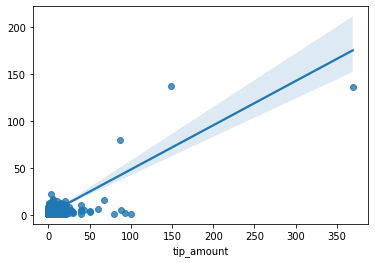

In [ ]:
sns.regplot(y_test,predictions)

In [ ]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 2.692e+04
Date:                Sat, 12 Feb 2022   Prob (F-statistic):               0.00
Time:                        03:11:19   Log-Likelihood:            -6.1276e+05
No. Observations:              340189   AIC:                         1.226e+06
Df Residuals:                  340178   BIC:                         1.226e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1020      0.442     

In [ ]:
result = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 54.31%


In [ ]:
y_predicted = reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predicted)

2.455729911001418

In [ ]:
print(y_predicted)

[1.9310841  2.24409067 1.6653513  ... 3.14600098 2.90708474 2.19106606]


In [ ]:
print(y_test)

700973    1.95
742364    2.36
292592    1.76
728549    1.50
928275    2.25
          ... 
88656     1.85
288268    3.42
161876    3.26
926222    2.85
844941    2.16
Name: tip_amount, Length: 85048, dtype: float64


ASSIGNMENT 1 ANSWERS 

Exploratory Data Analysis PART 1 

1. Feature Extraction using correlation matrix to check the relation between the variables for prediction; with the help of correlation matrix passenger count, trip distance, payment type start and end time and date are considered.

2. Relationship between the tip amount and various features are considered for better approach to the problem using scatter plot, box plot and bar graphs 

3. Feature transformation: time is represented with the level of time of the day, travel duration is calculated by separating the time stamp by converting into minutes and also speed is calculated with time and distance.

4. Output variable is transformed into tip percentage for better understanding of the problem.

PART 2: MODEL EVALUATING AND DATA PIPELINE
1. Data got split into train,validation, and test portions, and built a pipeline so that all models are trained on the training set and comparisons among models are performed on the validation set
2. Used linear regression model and trained the data set for prediction with 70:30 and 80:20 split ratio. where in the data the sign of each coefficient indicates the direction of the relationship between a predictor variable and the response variable.

*A positive sign indicates that as the predictor variable increases, the Target variable also increases.

*A negative sign indicates that as the predictor variable increases, the Target variable decreases.

3. Encoded time stamps in part one with respect to the single day trends by classifying them as 'morning', 'afternoon' and 'night'


